## HW07-Ising Model-Data Collection
## Paimah Safarian 96109628


In [39]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import random

Functon defination:

In [40]:
def initiate(l):
    grid = np.random.choice([-1, 1], (l, l))
    return grid

In [41]:
def neighbours(grid , i, j):
  l = np.shape(grid)[0]
  neighbours = [grid[i-1, j], grid[i, j-1], grid[i, (j+1)%l], grid[(i+1)%l, j]]
  return np.array(neighbours)

In [42]:
def energy_variation(grid, i, j):
  denergy = 2 * np.sum(grid[i, j] * neighbours(grid, i, j))
  return denergy


In [43]:
def energy(grid):
  l = np.shape(grid)[0]
  energy = 0
  for i in range(l):
    for j in range(l):
      energy -= np.sum(grid[i, j] * neighbours(grid, i, j))
  # energy = energy/2
  return energy

In [44]:
def magnetization(grid):
    return abs(np.mean(grid))

In [7]:
import statsmodels.api as sm

#calculate autocorrelations
def auto_corr(x):
    return sm.tsa.acf(x)

def corr_len(auto_corr, jump):
  fit = np.polyfit(np.log(np.arange(1, 9)), np.log(auto_corr[0:8]), 1)
  return (-1/fit[0] * jump)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [45]:
def correlation(grid):
  C_j = np.zeros(int(l/2))
  for distance in range(1, int(l/2)):
    sum_val = 0
    for i in range(0, l):
      sum_val += grid[0, i] * grid[0, (i + distance)%l]
    C_j[distance] = (sum_val/l - (np.mean(grid[0, :])) ** 2 )/np.var(grid[0, :])
    if np.abs(C_j[distance]) <= 1/np.e:
      return distance
  return 0
  

Want to save relaxation time for each $beta$:

In [ ]:
%%time

# J  = 1 and beta is the control parameter

beta_mat = np.append(np.append(np.arange(0.1, 0.4, 0.05), np.arange(0.41, 0.5, 0.01)), np.arange(0.505, 0.805, 0.05))

l    = 100
n    = l * l * 200
jump = 10 * l
grid = initiate(l)

denergy_mat  = [-8, -4, 0, 4, 8]
relaxation_time    = np.zeros(np.size(beta_mat))
boltzman_mat_beta  = np.zeros((np.size(beta_mat), 5))

for beta in beta_mat: 
  index = np.where(beta_mat == beta)[0][0]
  boltzman_mat = [1, 1, 1, np.e ** (-beta * 4), np.e ** (-beta * 8)]
  boltzman_mat_beta[index, :] = boltzman_mat

  energy_tot        = np.zeros(n)
  energy_tot[0]        = energy(grid)
  energy_value         = energy_tot[0]

  denergy = 0

  for step in range(n):
    i, j = np.random.randint(0, l, 2)

    denergy = energy_variation(grid, i, j)
    if denergy <= 0:
      grid[i, j] = -grid[i, j]
      energy_value   += denergy

    elif random.random() <= boltzman_mat[denergy_mat.index(denergy)]:
      grid[i, j] = -grid[i, j]
      energy_value   += denergy

    energy_tot[step]        = energy_value
 
  
  least_step = int(l * l)

  relaxation_time[index] = int(corr_len(auto_corr(energy_tot[least_step:-1:jump]), jump))

print(relaxation_time)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


[ 1016.  1324.  1723.  2003.  3335.  6431.  9552.  6657. 11443.  6497.
 23734. 11804. 13470.  8795.  8082.  7942.  7202.  6022.  6503.  5357.
  4102.  3955.  3840.  4267.]
CPU times: user 24min 53s, sys: 4.74 s, total: 24min 58s
Wall time: 24min 57s


In [9]:
relaxation_time = np.array([1016, 1324, 1723, 2003, 3335, 6431, 9552, 6657, 11443, 6497, 23734, 11804, 13470, 8795, 8082, 7942, 7202, 6022, 6503, 5357, 4102, 3955, 3840, 4267])

In [31]:
beta_mat = np.append(np.append(np.arange(0.1, 0.4, 0.05), np.arange(0.41, 0.5, 0.01)), np.arange(0.505, 0.805, 0.05))
boltzman_mat_beta  = np.zeros((np.size(beta_mat), 5))

for beta in beta_mat: 
  index = np.where(beta_mat == beta)[0][0]
  boltzman_mat = [1, 1, 1, np.e ** (-beta * 4), np.e ** (-beta * 8)]
  boltzman_mat_beta[index, :] = boltzman_mat


In [ ]:
np.savetxt("relaxationtime.csv", relaxation_time, delimiter=",")
np.savetxt("boltzman.csv", boltzman_mat_beta, delimiter=",")

Now we have relaxation time for every $beta$ values and also boltzman factors. Then we are going to save these data and then calculate the parameters just in some steps that we choose based on relaxation time value.

In [ ]:
from google.colab import files 
  
  
uploaded = files.upload()

import pandas as pd 
import io 
  
df = pd.read_csv(io.BytesIO(uploaded['relaxationtime.csv'])) 
print(df)

In [10]:
%%time

beta_mat = np.append(np.append(np.arange(0.1, 0.4, 0.05), np.arange(0.41, 0.5, 0.01)), np.arange(0.505, 0.805, 0.05))

l    = 100
n    = l * l * 200
jump = 10 * l
grid = initiate(l)

denergy_mat  = [-8, -4, 0, 4, 8]
b_size = np.size(beta_mat)
mean_energy        = np.zeros(b_size)
var_energy         = np.zeros(b_size)
mean_magnetization = np.zeros(b_size)
var_magnetization  = np.zeros(b_size)
mean_correlation_lenght = np.zeros(b_size)

for beta in beta_mat: 
  index = np.where(beta_mat == beta)[0][0]
  boltzman_mat =  boltzman_mat_beta[index, :]

  energy_tot        = []
  magnetization_tot = []
  correlation_lenght = []
  # energy_tot.append(energy(grid))
  # magnetization_tot.append(magnetization(grid))
  # energy_value         = energy_tot[0]

  least_step = int(l * l) * 100
  denergy = 0
  for step in range(n):
    i, j = np.random.randint(0, l, 2)
    denergy = energy_variation(grid, i, j)
    if denergy <= 0:
      grid[i, j] = -grid[i, j]
      # energy_value   += denergy

    elif random.random() <= boltzman_mat[denergy_mat.index(denergy)]:
      grid[i, j] = -grid[i, j]
      # energy_value   += denergy

    if step >= least_step and step % relaxation_time[index] == 0:
      energy_tot.append(energy(grid))
      magnetization_tot.append(magnetization(grid))
      correlation_lenght.append(correlation(grid))
    
  mean_energy[index]        = np.mean(energy_tot[:])
  var_energy[index]         = np.var(energy_tot[:])
  mean_magnetization[index] = np.mean(magnetization_tot[:])
  var_magnetization[index]  = np.var(magnetization_tot[:])
  mean_correlation_lenght[index] = np.mean(correlation_lenght[:])


CPU times: user 34min 40s, sys: 7.24 s, total: 34min 47s
Wall time: 34min 39s


In [ ]:
#plots

fig, axs = plt.subplots(5, 1, figsize=(7, 35))
energy
axs[0].errorbar(beta_mat, mean_energy, yerr = np.sqrt(var_energy), c = 'palevioletred')
axs[0].set(xlabel='\u03B2', ylabel='E(\u03B2)')
axs[0].set_title('$Mean Energy$')

#heat capacity
c_v = beta_mat ** 2 * var_energy
axs[1].plot(beta_mat, c_v, c = 'deepskyblue')
axs[1].set(xlabel='\u03B2', ylabel='$C_v(\u03B2)$')
axs[1].set_title('$Heat Capacity$')

#mean magnetization
axs[2].errorbar(beta_mat, mean_magnetization, yerr = np.sqrt(var_magnetization), c = 'sandybrown')
axs[2].set(xlabel='\u03B2', ylabel='M(\u03B2)')
axs[2].set_title('$MeanMagnetization$')

#susceptibility
chi = beta_mat * var_magnetization
axs[3].plot(beta_mat, chi, c = 'greenyellow')
axs[3].set(xlabel='\u03B2', ylabel='\u03C7(\u03B2)')
axs[3].set_title('$Susceptibility$')


#susceptibility
chi = beta_mat * var_magnetization
axs[4].plot(beta_mat, mean_correlation_lenght, c = 'gold')
axs[4].set(xlabel='\u03B2', ylabel='\u03CF(\u03B2)')
axs[4].set_title('$Correlation lenght$')


plt.savefig("parameters2.png")

In [23]:
print(correlation(grid))
print(grid[0,:])

0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [19]:
A = 0
k = 3

A += grid[i, k] * grid[i, (k+j)%l]
A

1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


[ 1.  1.  1.  2.  1.  2.  3.  2.  2.  3.  2.  4. 13.  8.  6. 11.  6.  0.
  1.  0.  1.  0.  1.  0.]
CPU times: user 24min 58s, sys: 7.58 s, total: 25min 6s
Wall time: 24min 56s


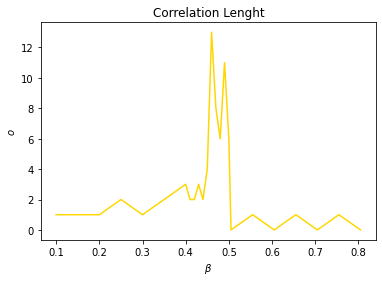

In [28]:
%%time

beta_mat = np.append(np.append(np.arange(0.1, 0.4, 0.05), np.arange(0.41, 0.5, 0.01)), np.arange(0.505, 0.805, 0.05))

l    = 100
n    = l * l * 200
jump = 10 * l
grid = initiate(l)

denergy_mat  = [-8, -4, 0, 4, 8]
b_size = np.size(beta_mat)
mean_energy        = np.zeros(b_size)
var_energy         = np.zeros(b_size)
mean_magnetization = np.zeros(b_size)
var_magnetization  = np.zeros(b_size)
mean_correlation_lenght = np.zeros(b_size)

for beta in beta_mat: 
  index = np.where(beta_mat == beta)[0][0]
  boltzman_mat = [1, 1, 1, np.e ** (-beta * 4), np.e ** (-beta * 8)] #boltzman_mat_beta[index, :]

  energy_tot        = []
  magnetization_tot = []
  correlation_lenght = []

  least_step = int(l * l) * 100
  denergy = 0
  for step in range(n):
    i, j = np.random.randint(0, l, 2)
    denergy = energy_variation(grid, i, j)
    if denergy <= 0:
      grid[i, j] = -grid[i, j]

    elif random.random() <= boltzman_mat[denergy_mat.index(denergy)]:
      grid[i, j] = -grid[i, j]

    if step >= least_step and step % relaxation_time[index] == 0:
      # energy_tot.append(energy(grid))
      # magnetization_tot.append(magnetization(grid))
      correlation_lenght.append(correlation(grid))
    
  # mean_energy[index]        = np.mean(energy_tot[:])
  # var_energy[index]         = np.var(energy_tot[:])
  # mean_magnetization[index] = np.mean(magnetization_tot[:])
  # var_magnetization[index]  = np.var(magnetization_tot[:])
  mean_correlation_lenght[index] = np.mean(correlation_lenght[correlation_lenght != 'nan'])

print(mean_correlation_lenght)
plt.plot(beta_mat, mean_correlation_lenght, c = 'gold')
plt.title("Correlation Lenght")
plt.ylabel('$\u03BF$')
plt.xlabel('$\u03B2$')

plt.savefig("Corr_len.png")

In [35]:
print(beta_mat, np.size(beta_mat))

[0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.41  0.42  0.43  0.44  0.45
 0.46  0.47  0.48  0.49  0.5   0.505 0.555 0.605 0.655 0.705 0.755 0.805] 24


In [46]:
%%time

beta_mat = np.append(np.append(np.arange(0.1, 0.4, 0.05), np.arange(0.41, 0.5, 0.01)), np.arange(0.505, 0.805, 0.05))

def parameters(l):
  n    = l * l * 100
  jump = 10 * l
  grid = initiate(l)

  denergy_mat  = [-8, -4, 0, 4, 8]
  b_size = np.size(beta_mat)
  mean_energy        = np.zeros(b_size)
  var_energy         = np.zeros(b_size)
  mean_magnetization = np.zeros(b_size)
  var_magnetization  = np.zeros(b_size)
  mean_correlation_lenght = np.zeros(b_size)

  #decreasing range of beta variation
  for index in range(3, 22):
    beta = beta_mat[index]
    # index = np.where(beta_mat == beta)[0][0]
    boltzman_mat =  boltzman_mat_beta[index, :]

    energy_tot        = []
    magnetization_tot = []
    correlation_lenght = []
  
    least_step = int(l * l) * 70
    denergy = 0
    for step in range(n):
      i, j = np.random.randint(0, l, 2)
      denergy = energy_variation(grid, i, j)
      if denergy <= 0:
        grid[i, j] = -grid[i, j]
    
      elif random.random() <= boltzman_mat[denergy_mat.index(denergy)]:
        grid[i, j] = -grid[i, j]
  
      if step >= least_step and step % relaxation_time[index] == 0:
        energy_tot.append(energy(grid))
        magnetization_tot.append(magnetization(grid))
        correlation_lenght.append(correlation(grid))
      
    mean_energy[index]        = np.mean(energy_tot[:])
    var_energy[index]         = np.var(energy_tot[:])
    mean_magnetization[index] = np.mean(magnetization_tot[:])
    var_magnetization[index]  = np.var(magnetization_tot[:])
    mean_correlation_lenght[index] = np.mean(correlation_lenght[:])

  return mean_energy, var_energy, mean_magnetization, var_magnetization, mean_correlation_lenght

CPU times: user 157 µs, sys: 0 ns, total: 157 µs
Wall time: 117 µs


In [37]:
%%time

for l in [130, 150, 180]:
  energy_m, energy_var, magnetization_m, magnetization_var, correlation_m = parameters(l)
  np.savetxt(f"energy_m{l}.csv", energy_m, delimiter=",")
  np.savetxt(f"energy_var{l}.csv", energy_var, delimiter=",")
  np.savetxt(f"magnetization_m{l}.csv", magnetization_m, delimiter=",")
  np.savetxt(f"magnetization_var{l}.csv", magnetization_var, delimiter=",")
  np.savetxt(f"correlation_m{l}.csv", correlation_m, delimiter=",")
  

CPU times: user 1h 36min 35s, sys: 19.7 s, total: 1h 36min 54s
Wall time: 1h 36min 32s


In [ ]:
%%time

for l in [100, 200]:
  energy_m, energy_var, magnetization_m, magnetization_var, correlation_m = parameters(l)
  np.savetxt(f"energy_m{l}.csv", energy_m, delimiter=",")
  np.savetxt(f"energy_var{l}.csv", energy_var, delimiter=",")
  np.savetxt(f"magnetization_m{l}.csv", magnetization_m, delimiter=",")
  np.savetxt(f"magnetization_var{l}.csv", magnetization_var, delimiter=",")
  np.savetxt(f"correlation_m{l}.csv", correlation_m, delimiter=",")
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
